# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 5

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter5()
# This is needed to render the plots in this chapter
from plots.chapter5 import *

In [3]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize

from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v1 import StepByStep

# Convolutions

## Filter / Kernel

![](./images/conv1.png)

In [4]:
single = np.array(
    [[[[5, 0, 8, 7, 8, 1],
       [1, 9, 5, 0, 7, 7],
       [6, 0, 2, 4, 6, 6],
       [9, 7, 6, 6, 8, 4],
       [8, 3, 8, 5, 1, 3],
       [7, 2, 7, 0, 1, 0]]]]
)
single.shape

(1, 1, 6, 6)

In [5]:
identity = np.array(
    [[[[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]]]]
)
identity.shape

(1, 1, 3, 3)

## Convolving

![](./images/conv2.png)

In [6]:
region = single[:, :, 0:3, 0:3]
filtered_region = region * identity
total = filtered_region.sum()
total

9

![](./images/conv3.png)

## Moving Around

![](./images/stride1.png)

In [7]:
new_region = single[:, :, 0:3, (0+1):(3+1)]

![](./images/conv5.png)

In [8]:
new_filtered_region = new_region * identity
new_total = new_filtered_region.sum()
new_total

5

![](./images/conv6.png)

![](./images/conv7.png)

In [9]:
last_horizontal_region = single[:, :, 0:3, (0+4):(3+4)]

In [10]:
last_horizontal_region * identity

ValueError: operands could not be broadcast together with shapes (1,1,3,2) (1,1,3,3) 

## Shape

![](./images/conv8.png)

$$
\Large
(h_i, w_i) * (h_f, w_f) = (h_i - (h_f - 1), w_i - (w_f - 1))
$$

$$
\Large
(h_i, w_i) * f = (h_i - f + 1, w_i - f + 1)
$$

## Convolving in PyTorch

In [11]:
image = torch.as_tensor(single).float()
kernel_identity = torch.as_tensor(identity).float()

In [12]:
convolved = F.conv2d(image, kernel_identity, stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

In [32]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
conv(image)

tensor([[[[-0.5369,  1.9690, -1.1619, -3.1844],
          [-0.8648, -4.0165, -0.3939, -0.4451],
          [-2.0863, -0.3478, -2.1432, -0.7654],
          [-2.5016, -2.5363, -1.0745, -1.8194]]]],
       grad_fn=<ConvolutionBackward0>)

In [21]:
conv_multiple = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
conv_multiple.weight

Parameter containing:
tensor([[[[-0.0390,  0.0643,  0.2987],
          [ 0.2798,  0.1787,  0.1787],
          [-0.2616,  0.1644,  0.2201]]],


        [[[ 0.2553, -0.0587,  0.0786],
          [ 0.1484,  0.3274, -0.2807],
          [-0.1516, -0.2343,  0.1902]]]], requires_grad=True)

In [37]:
with torch.no_grad():
    conv.weight[0] = kernel_identity
    conv.bias[0] = 0

In [38]:
conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

## Striding

![](./images/strider2.png)

![](./images/strider3.png)

$$
\Large
(h_i, w_i) * f = \left(\frac{h_i - f + 1}{s}, \frac{w_i - f + 1}{s}\right)
$$

In [39]:
convolved_stride2 = F.conv2d(image, kernel_identity, stride=2)
convolved_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

## Padding

![](./images/padding1.png)

In [40]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [41]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode='constant', value=0)

![](images/paddings.png)

In [42]:
replication_padder = nn.ReplicationPad2d(padding=1)
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In [43]:
reflection_padder = nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

In [44]:
F.pad(image, pad=(1, 1, 1, 1), mode='circular')

tensor([[[[0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.],
          [7., 1., 9., 5., 0., 7., 7., 1.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [4., 9., 7., 6., 6., 8., 4., 9.],
          [3., 8., 3., 8., 5., 1., 3., 8.],
          [0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.]]]])

$$
\Large
(h_i, w_i) * f = \left(\frac{(h_i + 2p) - f + 1}{s}, \frac{(w_i + 2p) - f + 1}{s}\right)
$$

## A REAL Filter

In [45]:
edge = np.array(
    [[[[0, 1, 0],
       [1, -4, 1],
       [0, 1, 0]]]]
)
kernel_edge = torch.as_tensor(edge).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

![](./images/padding2.png)

![](./images/padding3.png)

In [65]:
padded = F.pad(image, (1, 1, 1, 1), mode='constant', value=0)
conv_padded = F.conv2d(padded, kernel_edge, stride=1)

In [72]:
padded

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [73]:
conv_padded

tensor([[[[-19.,  22., -20., -12., -17.,  11.],
          [ 16., -30.,  -1.,  23.,  -7., -14.],
          [-14.,  24.,   7.,  -2.,   1.,  -7.],
          [-15., -10.,  -1.,  -1., -15.,   1.],
          [-13.,  13., -11.,  -5.,  13.,  -7.],
          [-18.,   9., -18.,  13.,  -3.,   4.]]]])

# Pooling

![](./images/pooling1.png)

In [74]:
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [75]:
maxpool4 = nn.MaxPool2d(kernel_size=4)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24.]]]])

In [76]:
F.max_pool2d(conv_padded, kernel_size=3, stride=1)

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

# Flattening

In [77]:
flattened = nn.Flatten()(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [78]:
pooled.view(1, -1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

# Typical Architecture

## LeNet5

![](images/architecture_lenet.png)

*Source: Generated using Alexander Lenail's [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author. For more details, see LeCun, Y., et al (1998).  [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Proceedings of the IEEE,86(11), 2278–2324*

In [79]:
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet.add_module('func1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('func3', nn.ReLU())
# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

# A Multiclass Classification Problem

## Data Generation

In [80]:
images, labels = generate_dataset(img_size=10, n_images=1000, binary=False, seed=17)

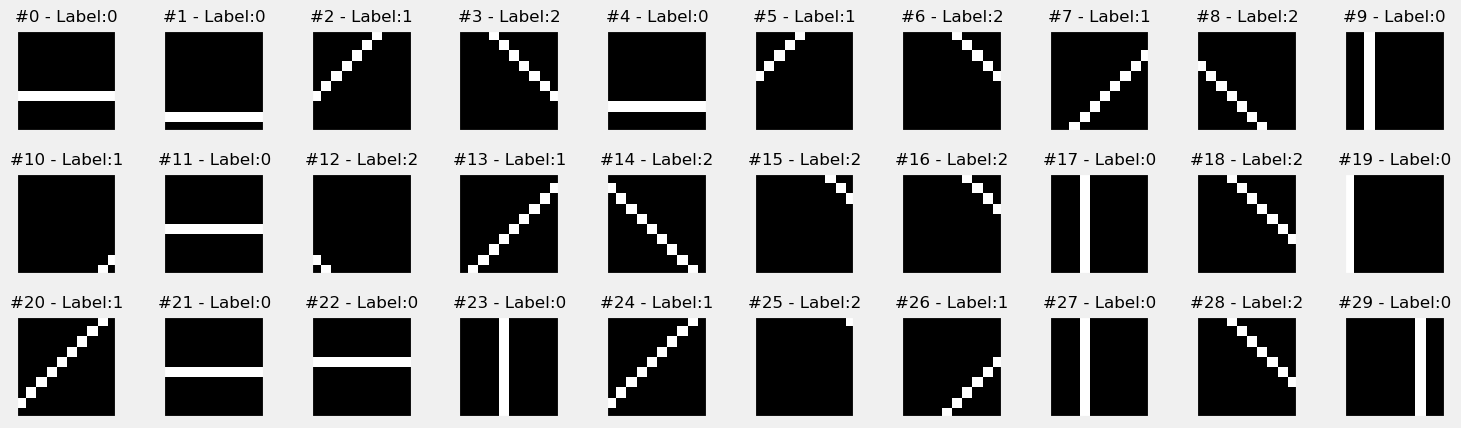

In [81]:
fig = plot_images(images, labels, n_plot=30)

## Data Preparation

In [82]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [83]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Loss

### Softmax

$$
\Large
\begin{aligned}
z & = \text{logit}(p) & &= \text{log odds ratio }(p) & &= \text{log}\left(\frac{p}{1-p}\right) & \\
e^z & = e^{\text{logit}(p)} & &= \text{odds ratio }(p) & &= \left(\frac{p}{1-p}\right) &
\end{aligned}
$$

$$
\Large
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{c=0}^{C-1}{e^{z_c}}}
$$

$$
\Large
\text{softmax}(z) = \left[\frac{e^{z_0}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_1}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_2}}{e^{z_0}+e^{z_1}+e^{z_2}}\right]
$$

In [ ]:
logits = torch.tensor([ 1.3863,  0.0000, -0.6931])

In [ ]:
odds_ratios = torch.exp(logits)
odds_ratios

In [ ]:
softmaxed = odds_ratios / odds_ratios.sum()
softmaxed

In [ ]:
nn.Softmax(dim=-1)(logits), F.softmax(logits, dim=-1)

### Negative Log Likelihood Loss

$$
\Large
\texttt{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
\\
\Large
\texttt{NLLLoss}(y)={-\frac{1}{(N_0+N_1+N_2)}\Bigg[{\sum_{i=1}^{N_0}{\text{log}(\text{P}(y_i=0))} + \sum_{i=1}^{N_1}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_2}{\text{log}(\text{P}(y_i=2))}}\Bigg]}
\\
\Large \texttt{NLLLoss}(y)={-\frac{1}{(N_0+\cdots+N_{C-1})}\sum_{c=0}^{C-1}{\sum_{i=1}^{N_c}{\text{log}(\text{P}(y_i=c))} }}
$$

In [ ]:
log_probs = F.log_softmax(logits, dim=-1)
log_probs

In [ ]:
label = torch.tensor([2])
F.nll_loss(log_probs.view(-1, 3), label)

In [ ]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])
dummy_log_probs = F.log_softmax(dummy_logits, dim=-1)
dummy_log_probs

In [ ]:
relevant_log_probs = torch.tensor([-1.5229, -1.7934, -1.0136, -2.0367, -1.9098])
-relevant_log_probs.mean()

In [ ]:
loss_fn = nn.NLLLoss()
loss_fn(dummy_log_probs, dummy_labels)

In [ ]:
loss_fn = nn.NLLLoss(weight=torch.tensor([1., 1., 2.]))
loss_fn(dummy_log_probs, dummy_labels)

In [ ]:
loss_fn = nn.NLLLoss(ignore_index=2)
loss_fn(dummy_log_probs, dummy_labels)

### Cross Entropy Loss

In [ ]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])

loss_fn = nn.CrossEntropyLoss()
loss_fn(dummy_logits, dummy_labels)

## Model Configuration

In [ ]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

In [ ]:
# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

![](images/classification_softmax.png)

In [ ]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

## Model Training

In [ ]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)

In [ ]:
sbs_cnn1.train(20)

In [ ]:
fig = sbs_cnn1.plot_losses()

## Visualizing Filters and More!

In [ ]:
@staticmethod
def _visualize_tensors(axs, x, y=None, yhat=None, 
                       layer_name='', title=None):
    # The number of images is the number of subplots in a row
    n_images = len(axs)
    # Gets max and min values for scaling the grayscale
    minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
    # For each image
    for j, image in enumerate(x[:n_images]):
        ax = axs[j]
        # Sets title, labels, and removes ticks
        if title is not None:
            ax.set_title(f'{title} #{j}', fontsize=12)
        shp = np.atleast_2d(image).shape
        ax.set_ylabel(
            f'{layer_name}\n{shp[0]}x{shp[1]}',
            rotation=0, labelpad=40
        )
        xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
        xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
        xlabel = f'{xlabel1}{xlabel2}'
        if len(xlabel):
            ax.set_xlabel(xlabel, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

        # Plots weight as an image
        ax.imshow(
            np.atleast_2d(image.squeeze()),
            cmap='gray', 
            vmin=minv, 
            vmax=maxv
        )
    return

setattr(StepByStep, '_visualize_tensors', _visualize_tensors)

### Static Method

In [ ]:
class Cat(object):
    def __init__(self, name):
        self.name = name

    @staticmethod
    def meow():
        print('Meow')

In [ ]:
Cat.meow()

### Visualizing Filters

In [ ]:
weights_filter = model_cnn1.conv1.weight.data.cpu().numpy()
weights_filter.shape

In [ ]:
def visualize_filters(self, layer_name, **kwargs):
    try:
        # Gets the layer object from the model
        layer = self.model
        for name in layer_name.split('.'):
            layer = getattr(layer, name)
        # We are only looking at filters for 2D convolutions
        if isinstance(layer, nn.Conv2d):
            # Takes the weight information
            weights = layer.weight.data.cpu().numpy()
            # weights -> (channels_out (filter), channels_in, H, W)
            n_filters, n_channels, _, _ = weights.shape

            # Builds a figure
            size = (2 * n_channels + 2, 2 * n_filters)
            fig, axes = plt.subplots(n_filters, n_channels, 
                                     figsize=size)
            axes = np.atleast_2d(axes)
            axes = axes.reshape(n_filters, n_channels)
            # For each channel_out (filter)
            for i in range(n_filters):    
                StepByStep._visualize_tensors(
                    axes[i, :],
                    weights[i],
                    layer_name=f'Filter #{i}', 
                    title='Channel'
                )
                    
            for ax in axes.flat:
                ax.label_outer()

            fig.tight_layout()
            return fig
    except AttributeError:
        return
    
setattr(StepByStep, 'visualize_filters', visualize_filters)

In [ ]:
fig = sbs_cnn1.visualize_filters('conv1', cmap='gray')

### Hooks

In [ ]:
dummy_model = nn.Linear(1, 1)

dummy_list = []

def dummy_hook(layer, inputs, outputs):
    dummy_list.append((layer, inputs, outputs))

In [ ]:
dummy_handle = dummy_model.register_forward_hook(dummy_hook)
dummy_handle

In [ ]:
dummy_x = torch.tensor([0.3])
dummy_model.forward(dummy_x)

In [ ]:
dummy_list

In [ ]:
dummy_model(dummy_x)

In [ ]:
dummy_list

In [ ]:
dummy_handle.remove()

In [ ]:
modules = list(sbs_cnn1.model.named_modules())
modules

In [ ]:
layer_names = {layer: name for name, layer in modules[1:]}
layer_names

In [ ]:
visualization = {}

def hook_fn(layer, inputs, outputs):
    name = layer_names[layer]
    visualization[name] = outputs.detach().cpu().numpy()

In [ ]:
layers_to_hook = ['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2']

handles = {}

for name, layer in modules:
    if name in layers_to_hook:
        handles[name] = layer.register_forward_hook(hook_fn)

In [ ]:
images_batch, labels_batch = next(iter(val_loader))
logits = sbs_cnn1.predict(images_batch)

In [ ]:
visualization.keys()

In [ ]:
for handle in handles.values():
    handle.remove()
handles = {}

In [ ]:
setattr(StepByStep, 'visualization', {})
setattr(StepByStep, 'handles', {})

def attach_hooks(self, layers_to_hook, hook_fn=None):
    # Clear any previous values
    self.visualization = {}
    # Creates the dictionary to map layer objects to their names
    modules = list(self.model.named_modules())
    layer_names = {layer: name for name, layer in modules[1:]}

    if hook_fn is None:
        # Hook function to be attached to the forward pass
        def hook_fn(layer, inputs, outputs):
            # Gets the layer name
            name = layer_names[layer]
            # Detaches outputs
            values = outputs.detach().cpu().numpy()
            # Since the hook function may be called multiple times
            # for example, if we make predictions for multiple mini-batches
            # it concatenates the results
            if self.visualization[name] is None:
                self.visualization[name] = values
            else:
                self.visualization[name] = np.concatenate([self.visualization[name], values])

    for name, layer in modules:
        # If the layer is in our list
        if name in layers_to_hook:
            # Initializes the corresponding key in the dictionary
            self.visualization[name] = None
            # Register the forward hook and keep the handle in another dict
            self.handles[name] = layer.register_forward_hook(hook_fn)

def remove_hooks(self):
    # Loops through all hooks and removes them
    for handle in self.handles.values():
        handle.remove()
    # Clear the dict, as all hooks have been removed
    self.handles = {}
    
setattr(StepByStep, 'attach_hooks', attach_hooks)
setattr(StepByStep, 'remove_hooks', remove_hooks)

In [ ]:
sbs_cnn1.attach_hooks(layers_to_hook=['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2'])

In [ ]:
images_batch, labels_batch = next(iter(val_loader))
logits = sbs_cnn1.predict(images_batch)

In [ ]:
sbs_cnn1.remove_hooks()

In [ ]:
predicted = np.argmax(logits, 1)
predicted

### Visualizing Feature Maps

In [ ]:
fig = plot_images(images_batch.squeeze(), labels_batch.squeeze(), n_plot=10)

In [ ]:
def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
    layers = filter(lambda l: l in self.visualization.keys(), layers)
    layers = list(layers)
    shapes = [self.visualization[layer].shape for layer in layers]
    n_rows = [shape[1] if len(shape) == 4 else 1 
              for shape in shapes]
    total_rows = np.sum(n_rows)

    fig, axes = plt.subplots(total_rows, n_images, 
                             figsize=(1.5*n_images, 1.5*total_rows))
    axes = np.atleast_2d(axes).reshape(total_rows, n_images)
    
    # Loops through the layers, one layer per row of subplots
    row = 0
    for i, layer in enumerate(layers):
        start_row = row
        # Takes the produced feature maps for that layer
        output = self.visualization[layer]
            
        is_vector = len(output.shape) == 2
        
        for j in range(n_rows[i]):
            StepByStep._visualize_tensors(
                axes[row, :],
                output if is_vector else output[:, j].squeeze(),
                y, 
                yhat, 
                layer_name=layers[i] \
                           if is_vector \
                           else f'{layers[i]}\nfil#{row-start_row}',
                title='Image' if (row == 0) else None
            )
            row += 1
            
    for ax in axes.flat:
        ax.label_outer()

    plt.tight_layout()
    return fig

setattr(StepByStep, 'visualize_outputs', visualize_outputs)

In [ ]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']

with plt.style.context('seaborn-white'):
    fig = sbs_cnn1.visualize_outputs(featurizer_layers)

### Visualizing Classifier Layers

In [ ]:
classifier_layers = ['fc1', 'relu2', 'fc2']

with plt.style.context('seaborn-white'):
    fig = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

### Accuracy

In [ ]:
def correct(self, x, y, threshold=.5):
    self.model.eval()
    yhat = self.model(x.to(self.device))
    y = y.to(self.device)
    self.model.train()
    
    # We get the size of the batch and the number of classes 
    # (only 1, if it is binary)
    n_samples, n_dims = yhat.shape
    if n_dims > 1:        
        # In a multiclass classification, the biggest logit
        # always wins, so we don't bother getting probabilities
        
        # This is PyTorch's version of argmax, 
        # but it returns a tuple: (max value, index of max value)
        _, predicted = torch.max(yhat, 1)
    else:
        n_dims += 1
        # In binary classification, we NEED to check if the
        # last layer is a sigmoid (and then it produces probs)
        if isinstance(self.model, nn.Sequential) and \
           isinstance(self.model[-1], nn.Sigmoid):
            predicted = (yhat > threshold).long()
        # or something else (logits), which we need to convert
        # using a sigmoid
        else:
            predicted = (F.sigmoid(yhat) > threshold).long()
    
    # How many samples got classified correctly for each class
    result = []
    for c in range(n_dims):
        n_class = (y == c).sum().item()
        n_correct = (predicted[y == c] == c).sum().item()
        result.append((n_correct, n_class))
    return torch.tensor(result)

setattr(StepByStep, 'correct', correct)

In [ ]:
sbs_cnn1.correct(images_batch, labels_batch)

### Loader Apply

In [ ]:
@staticmethod
def loader_apply(loader, func, reduce='sum'):
    results = [func(x, y) for i, (x, y) in enumerate(loader)]
    results = torch.stack(results, axis=0)

    if reduce == 'sum':
        results = results.sum(axis=0)
    elif reduce == 'mean':
        results = results.float().mean(axis=0)
    
    return results

setattr(StepByStep, 'loader_apply', loader_apply)

In [ ]:
StepByStep.loader_apply(sbs_cnn1.val_loader, sbs_cnn1.correct)

## Putting It All Together

### Data Preparation

In [ ]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Model Configuration

In [ ]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

### Model Training

In [ ]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)
sbs_cnn1.train(20)

### Visualizing Filters

In [ ]:
fig_filters = sbs_cnn1.visualize_filters('conv1', cmap='gray')

### Capturing Outputs

In [ ]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']
classifier_layers = ['fc1', 'relu2', 'fc2']

sbs_cnn1.attach_hooks(layers_to_hook=featurizer_layers + classifier_layers)

images_batch, labels_batch = next(iter(val_loader))
logits = sbs_cnn1.predict(images_batch)
predicted = np.argmax(logits, 1)

sbs_cnn1.remove_hooks()

### Visualizing Feature Maps

In [ ]:
with plt.style.context('seaborn-white'):
    fig_maps1 = sbs_cnn1.visualize_outputs(featurizer_layers)
    fig_maps2 = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)    

### Accuracy

In [ ]:
StepByStep.loader_apply(sbs_cnn1.val_loader, sbs_cnn1.correct)